In [127]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.fft as fft
import scipy.interpolate as interpolate
import pandas as pd
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import minimize


## FFT - Fast Fourier Transformation

$$f(x) = \frac{1}{2\pi} \int_{ - \infty}^{+ \infty} e^{-izx} \phi (z)dz$$
if we want to calculate the density for many $x$ we need to compute an integral, this can be very computational expensive if we need it for many $x$.
Let us formulate the pricing problem:
$$ \mathbb{E}\bigg(\frac{V(T)}{M(T)}\bigg) = \int_{\mathbb{R}} e^{-rT} \cdot \Pi(T) \cdot f_X(x) dx$$
In this case we need to discretize the integral and for each $X$ in our domain we need to evaluate  the intefral above.
FFT can help to get a much more faster implementation.


## Inversion Lemma

Let $\phi(z)$ be a characteristic function and $f(x)$ be a probability density function of some continuos variable X. Then we have:
$$ f(x) = \frac{1}{\pi} \mathcal{R}\bigg(\int_0^{ + \infty} e^{-izx} \phi(z) dz\bigg)$$

## Proof:
from Fourier Inverse:
$$ f(x) = \frac{1}{2\pi} \int_{ - \infty}^{+ \infty} e^{-izx} \phi (z)dz$$
$$f(x) = \frac{1}{2\pi}\bigg(  \int_{ - \infty}^{0} e^{-izx} \phi (z)dz +  \int_{0}^{ \infty} e^{-izx} \phi (z)dz\bigg) $$


where the first integral on the RHS can be written as:
$$\int_{ - \infty}^{0} e^{-izx} \phi (z)dz = \int_{0}^{\infty} e^{ivx} \phi (-v)dv$$
By taking the conjugate of the first integral and using the fact that the conjugate of an exponent equals the exponent of the conjugate, we find:
$$ \int_{0}^{\infty} e^{ivx} \phi (-v)dv = \int_{0}^{\infty} \overline{e^{-izx} \phi (z)}dz = \overline{\int_{0}^{\infty} {e^{-izx} \phi (z)}dz } $$

using the property of complex numbers $ z +\overline{z}=2 \mathcal{R}(z)$ therefore the density can be expressed as:
$$ f(x) = \frac{1}{\pi} \mathcal{R}\bigg(\int_0^{\infty} e^{-izx}\phi(z) dz \bigg) $$

$$f(x) = \frac{1}{2\pi}\bigg( \overline{\int_{0}^{\infty} {e^{-izx} \phi (z)}dz } +  \int_{0}^{ \infty} e^{-izx} \phi (z)dz\bigg) $$ 
$$ f(x) = \frac{1}{\pi} \mathcal{R}\bigg(\int_0^{\infty} e^{-izx}\phi(z) dz \bigg) $$


Given that we discretize the domain for \( x \) and \( z \) into \( N \) grid points, we consider the vectors $f, \phi \in \mathbb{C}^N $:
$$
f = \begin{pmatrix}
f_1 \\
f_2 \\
\vdots \\
f_{N-1} \\
f_N 
\end{pmatrix}
$$

$$
\phi = \begin{pmatrix}
\phi_1 \\
\phi_2 \\
\vdots \\
\phi_{N-1} \\
\phi_N 
\end{pmatrix}
$$

Let us consider the following representation:
$$ \int_0^{\infty} e^{-izx}\phi(z)dz \coloneqq \ \int_0^{\infty} \gamma(z)dz $$

We define  a trapezoidal integration over domain $[0, z_{max}]$ for which we have:
$$ \int_0^{z_{max}} \gamma(z)d(z) \approx \frac{\Delta_z}{2}\bigg[\gamma(z_1) + 2 \sum_{2}^{N-1} \gamma(z_n) + \gamma{z_N}\bigg]$$


$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=2}^{N-1} \gamma(z_n) + \frac{1}{2} \gamma(z_1) + \frac{1}{2} \gamma(z_N) \right]
$$


- $z_{max} = N\Delta_z$
- $z_n = (n-1)\Delta_z$
- $x_k= x_{min} + \Delta_x(k-1)$

$x_min=b$ is a tuning parameter which can be freely chosen, typically it should be associated with a low quantile of distribution such that $P[X<b]< \epsilon $

we have to specify $\Delta_z$ interval, the number of points and the $x_{min}$

$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=1}^{N} e^{-i[(n-1)\Delta_z][+x_{min} + \Delta_x(k-1)]} \phi(z_n)  - \frac{1}{2}\bigg[e^{-ixz_1} \phi(z_1) + e^{ixz_N}\phi(z_N)\bigg]\right]
$$
$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=1}^{N} e^{-i\Delta_x\Delta_z(n-1)(k-1)}e^{-i(n-1)x_{min}\Delta_z} \phi(z_n)  - \frac{1}{2}\bigg[e^{-ixz_1} \phi(z_1) + e^{-ixz_N}\phi(z_N)\bigg]\right]
$$


if we set:
$$ \Delta_x\Delta_z = \frac{2\pi}{N}$$
and since $z= (n-1)\Delta_z$
we obtain:
$$
\int_0^{z_{max}} \gamma(z) \, d(z) \approx \Delta_z \left[ \sum_{n=1}^{N} e^{-i\frac{2\pi}{N}(n-1)(k-1)}e^{-ix_{min}z} \phi(z_n)  - \frac{1}{2}\bigg[e^{-ixz_1} \phi(z_1) + e^{-ixz_N}\phi(z_N)\bigg]\right]
$$

so finally we obtain:
$$ f(x) = \frac{1}{\pi} \mathcal{R} \bigg(\int_0^{\infty} e^{-izx}\phi(z)dz\bigg) = \frac{\Delta_z}{\pi} \mathcal{R}\left( \left[ \sum_{n=1}^{N} e^{-i\frac{2\pi}{N}(n-1)(k-1)}e^{-ix_{min}z} \phi(z_n)  - \frac{1}{2}(\gamma_1 + \gamma_2)\right] \right)$$

where $\gamma_1=e^{-ixz_1} \phi(z_1)$ and $\gamma_2 = e^{-ixz_N}\phi(z_N)$

In the following representation we have a considered a fixed grid for x_k, howeveris not ensured that x in $f(x)$ is a point in the grid. For that reason, typically an interpolation between grid of points of $x_k$ is considered.

It is necessary to perform a matrix multiplication which requires around $N^2$ (complex) mulitplications and $N^2$ additions, the number of arithmetic operations is of order $N^2$ $\mathcal{O}(N^2)$
- It is possible to have Discretized fourier transform (DFT) evaluated in $\mathcal{O}(N log_2 N)$ operations.
- The algorithm was called FFT, available in many computer languages

Again we discretize the domain for x, and z into N grid points and we consider the vectors $f,\phi \in \mathbb{C}^N$
$$
f = \begin{pmatrix}
f_1 \\
f_2 \\
\vdots \\
f_{N-1} \\
f_N 
\end{pmatrix}
$$

$$
\phi = \begin{pmatrix}
\phi_1 \\
\phi_2 \\
\vdots \\
\phi_{N-1} \\
\phi_N 
\end{pmatrix}
$$

the discrete Fourier transform $f$ of $phi$ is given by the matrix multiplication:
$$ f = M\phi$$
or equivalently:
$$f_k= \sum_{n=1}^{N} \phi_n e^{-i\frac{2\pi}{N}(n-1)(k-1)}=\sum_{n=1}^{N} \phi_n \bar{w}_N^{(n-1)(k-1)} $$

the discretized Fourier Transform matrix $M \in \mathbb{C}^{N \times N}$ is then defined as:
$$
M= \begin{pmatrix}
1 & 1 & 1 & ...& 1 \\
1 & \bar{w}_N^1 & \bar{w}_N^2 & ... &  \bar{w}_N^{N-1}  \\
1 & \bar{w}_N^2 & \bar{w}_N^4 & ... &  \bar{w}_N^{2(N-1)} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \bar{w}_N^{N-1} & \bar{w}_N^{N(N-1)} & ... &  \bar{w}_N^{(N-1)(N-1)} \\
\end{pmatrix}
$$


$$M_{n,k}= \bar{w}_N^{(n-1)(k-1)}

with $N=2^L$(even). <br>
Define $x_n = \phi_{2_{n-1}}$ and $y_n$ $y_n = \phi_2{n}$ for $n=1, ..., N/2$ $(x_n , y_n)$ are the odd and even sequences of $\phi_n$

$$f_k= \sum_{n=1}^{N/2}x_n \bar{w}_N^{(2n-2)(k-1)} + y_n \bar{w}_N^{(2n-1)(k-1)}$$
for $k=1, ..., N$

 $$

the basis behind the FFT is the simple but crucial equality:
$$\bar{w}_N^{(2_n-2)(k-1)} = \bar{w}_{N/2}^{(n-1)(k-1)}$$

$$f_k= \sum_{n=1}^{N/2}x_n \bar{w}_{N/2}^{(n-1)(k-1)} + \bar{w}_{N}^{(k-1)} \sum_{n=1}^{N/2} y_n \bar{w}^{(2n-1)(k-1)}= Z_k + \bar{w}_{N}^{(k-1)} Y_k $$
which is apart from a facotr $ \bar{w}_{N}^{(k-1)}$ the sum of two DFTs, each of length $N/2$. <br> 
Hence we can write:
$$ f_k = Z_k + \bar{w}_N^{k-1}Y_k$$
$$ f_{k+ N/2} = Z_{k + N/2} +\bar{w}_{N}^{(k-1) + N/2} Y_{k + N/2}$$
for $k=1, ..., N/2$

Taking the characteristic function for a normal random varialble $\mathcal{N}(\mu,\sigma^2)$:
$$\phi_X(\mu) = e^{i\mu z - \frac{1}{2}\sigma^2z^2} $$
can be interesting comparing the original pdf with the FFT approximation.

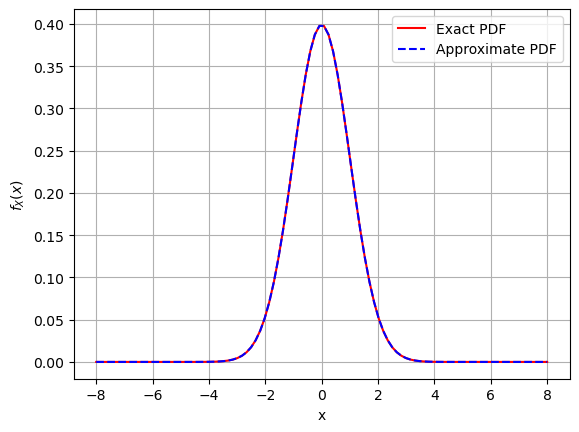

In [128]:
def RecoverDensity(cf, x, N=8192):
    i = complex(0.0, 1.0)  # assigning i=sqrt(-1)

    # specification of the grid for u
    z_max = 20.0
    dz = z_max / N
    z = np.linspace(0, N-1, N) * dz

    # grid for x
    b = np.min(x)
    dx = 2.0 * np.pi / (N * dz)
    x_i = b + np.linspace(0, N-1, N) * dx

    phi = np.exp(-i * b * z) * cf(z)

    gamma_1 = np.exp(-i * x_i * z[0]) * cf(z[0])
    gamma_2 = np.exp(-i * x_i * z[-1]) * cf(z[-1])

    phi_boundary = 0.5 * (gamma_1 + gamma_2)

    f_xi = dz / np.pi * np.real(fft.fft(phi) - phi_boundary)

    f_xiInterp = interpolate.interp1d(x_i, f_xi, kind='cubic')

    return f_xiInterp(x)

def mainCalculation():
    i = complex(0.0, 1.0)  # assigning i=sqrt(-1)

    # setting for normal distribution
    mu = 0.0
    sigma = 1.0

    # Define characteristic function for the normal distribution
    cF = lambda z: np.exp(i * mu * z - 0.5 * sigma**2.0 * z**2.0)

    # define domain for density
    x = np.linspace(-8.0, 8.0, 100)
    f_XExact = st.norm.pdf(x, mu, sigma)

    # recovered density
    f_XR = RecoverDensity(cF, x)

    plt.figure(1)
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("$f_X(x)$")
    plt.plot(x, f_XExact, '-r', label="Exact PDF")
    plt.plot(x, f_XR, '--b', label="Approximate PDF")
    plt.legend()
    plt.show()

mainCalculation()

## Fourier-Cosine Expansion (COS method)
- Exponential convergence,
- Greeks are obtained at no additional cost <br>
The basic idea is to replace the density by its Fourier-cosine series expansion. <br>
The density and its characteristic function, $f_X(y) \text{and} \phi_X(z)$ form a Fourier pair,
- $\phi_X(z)= \int_{\mathbb{R}}e^{iyz}f_X(y) dy$ <br>
- $f_X(y)= \frac{1}{2\pi} \int_{\mathbb{R}}e^{-iyz} \phi_X(z) dz$

 Fourier cosine series expansions give an optimal approximation of functions with a finite support.
 Definition of the Fourier expansion of a function $g(x)$ on $[-1,1]$:
 $$ g(\theta) = \sum_{k=0}^{'\infty} \bar{A}_k cos(k\pi\theta) + \sum_{k=1}^{\infty} \bar{B}_k sin(k\pi\theta) $$
 where the $'$ at the first sum, indicates that the first term in the sum is weighted by one half, and the coefficients are given by:
 - $\bar{A}_k = \int_{-1}^{1}g(\theta) cos(k\pi\theta)d\theta$,
 - $\bar{B}_k = \int_{-1}^{1}g(\theta) sin(k\pi\theta)d\theta$

By setting $\bar{B}_k=0$ we obtain the classical Fourier Cosine expansion, by which we can represent even functions around $\theta=0$ exactly.
We can extend any function $g: [0,\pi] \Rightarrow \mathbb{R}$ to become an even function on $[-\pi,\pi]$ as follows,
$$ \bar{g}(\theta)=\begin{cases} g(\theta), \theta > 0 \\
                            g(-\theta), \theta < 0 \end{cases}$$

Even functions can be expressed as Fourier Cosine series.

For a function $\bar{g}(\theta)$:
$$ \bar{g}(\theta) = \sum_{k=0}^{'\infty} \bar{A}_k cos(k\theta) $$

with: 
- $\bar{A}_k = \frac{1}{\pi} \int_{-\pi}^{\pi}\bar{g}(\theta) cos(\pi\theta)d\theta$ = $\bar{A}_k = \frac{2}{\pi} \int_{0}^{\pi}g(\theta) cos(\pi\theta)d\theta$
The Fourier Cosine series expansion, as used in the COS method, is based on a classical definition of the cosine series in the interval $[-\pi,\pi]$ with $\pi$ being a merely scaling factor, and the function maximum is attaiend at the domain boundary 

Because $g(\theta) = \bar{g}(\theta)$ on $[0,\pi]$ the Fourier Cosine expansion of the function $g(\theta)$ on $[0,\pi]$ is also given by the previous equation

for functions supported on any other finite interval, say $[a,b] \in \mathbb{R}$ the Fourier cosine series expansion can be obtained via a change of variables:
$$ \theta \coloneqq \frac{y-a}{b-a} \pi, y = \frac{b-a}{\pi} \theta + a$$

It then reads:
$$ g(y) = \sum_{k=0}^{\infty}  \bar{A}_k \cdot cos \bigg(k\pi \frac{y-a}{b-a}\bigg) $$

with: $$  \bar{A}_k = \frac{2}{b-a} \int_{a}^{b} g(y) cos(k\pi \frac{y-a}{b-a})dy$$

Suppose $[a,b] \in \mathbb{R}$ is chosen such that the truncated integral approximates the infinite counterpart very well, i.e,
$$ \hat{\phi}_X(z) \coloneqq \int_a^b e^{izy}f_X(y)dy \approx\int_{\mathbb{R}} e^{izy}f_X(y)dy

By recalling the Euler Formula:
$$ e^{iz} = cos(z) + isin(z)$$
which implies $\mathcal{R}(e^{iz}) = cos(z)$, with $\mathbb{R}(.)$ the real part

For random variable $X$ and $a \in \mathbb{R}$:
$$ \phi_X(z)e^{ia} = \mathbb{E}[e^{izX + ia}] = \int_{-\infty}^{\infty}e^{i(zy +a)}f_X(y)dy$$

By taking the real parts in (14),
$$ \mathcal{R}(\phi_X(z)e^{ia}) = \mathcal{R}\bigg(  \int_{-\infty}^{\infty}e^{i(zy +a)}f_X(y)dy\bigg) =   \int_{-\infty}^{\infty}cos(zy +a)f_X(y)dy

Substitute $z= \frac{k\pi}{b-a}$ and multiply $\hat{\phi}(x)$ by $ e^{-i\frac{ka\pi}{b-a}}$: 
$$  \hat{\phi}_X(\frac{k\pi}{b-a}) \cdot e^{-i \frac{ka\pi}{b-a}} = \int_a^b exp\bigg( iy \frac{k\pi}{b-a} - i \frac{ka\pi}{b-a}\bigg) f_X(y)dy$$

Taking the real part at both sides:
$$  \mathcal{R}\bigg(\hat{\phi}_X(\frac{k\pi}{b-a}) \cdot e^{-i \frac{ka\pi}{b-a}}\bigg) = \int_a^b f_X(y) cos\bigg(k\pi\frac{y-a}{b-a}\bigg) dy$$

It follows that $\bar{A}_k \approx \bar{F}_k$ with:
$$\bar{F}_k \coloneqq \frac{2}{b-a} \mathcal{R}\bigg(\phi_X\bigg(\frac{k\pi}{b-a}\bigg) \cdot exp\bigg(-i \frac{ka\pi}{b-a}\bigg)\bigg)$$

substituying $\bar{A}_k$ with $\bar{F}_k$ in the series expansion of $f_X(y)$ on $[a,b],$ i.e,
$$ \hat{f}_X(y) \approx \sum_{k=0}^{'N-1} \bar{F}_k cos\bigg(k\pi \frac{y-a}{b-a}\bigg)

$\sum^{'}$ indicates that the first element of the summation should be multiplied by $\frac{1}{2}$

- series truncation error, from approximating $\bar{A}_k$ by $\bar{F}_k$: the error is coming from a finite number of expansion term
- domain approximation for $[a,b]$
- if the function is entire (it is complex derivable in a neighbourhood of points) the algorithm converge exponentially

## Summary on COS Method and Density Recovery
- Fourier Cosine expansion of density function on interval $[a,b]$
$$ \bar{f}(x) = \sum_{n=0}^{'N-1} \bar{F}_n cos\bigg(n\pi\frac{x-a}{b-a}\bigg)$$
with $x \in [a,b] \subset \mathbb{R}$ and the coefficents defined as:
$$ \bar{F}_n \coloneqq \frac{2}{b-a}\int_{a}^{b} f(x)cos\bigg(n\pi\frac{x-a}{b-a}\bigg)dx.$$
$$ \bar{F}_n \coloneqq \frac{2}{b-a} \mathcal{R}\bigg(\phi\bigg(\frac{n\pi}{b-a} exp{-i\frac{na\pi}{b-a}}\bigg)\bigg).$$

## Recovering density
PDF and characteristic function are known in closed form, and read respectively:
$$ f_{\mathcal{N}(0,1)}(y) =\frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}}y^2$$
$$\phi_{\mathcal{N}(0,1)(u)}=e^{-\frac{1}{2}u}

For 4 expanansion terms the error is 0.2537377837565189
For 8 expanansion terms the error is 0.10751732725194052
For 16 expanansion terms the error is 0.007172377614980574
For 32 expanansion terms the error is 4.0323407890507923e-07
For 64 expanansion terms the error is 2.5766861978445515e-16


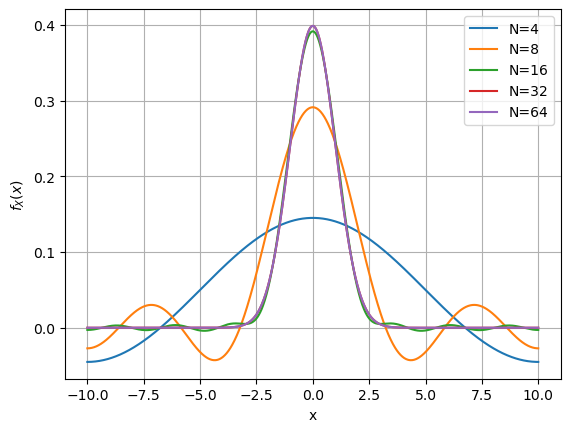

In [129]:
#%%
"""
Normal density recovery using the COS method
"""

def COSDensity(cf,x,N,a,b):
    i = complex(0.0,1.0) #assigning i=sqrt(-1)
    k = np.linspace(0,N-1,N)
    z= np.zeros([1,N])
    z = k * np.pi / (b-a)
        
    #F_k coefficients
    F_k    = 2.0 / (b - a) * np.real(cf(z) * np.exp(-i * z * a));
    F_k[0] = F_k[0] * 0.5; # adjustment for the first term
    
    #Final calculation
    f_X = np.matmul(F_k , np.cos(np.outer(z, x - a )))
        
    # we output only the first row
    return f_X
    
def mainCalculation():
    i = complex(0.0, 1.0) #assigning i=sqrt(-1)
    
    # setting for the COS method 
    a = -10.0
    b = 10.0
    
    #define the range for the expansion points
    N = [2**x for x in range(2,7,1)]
    
    # setting for normal distribution
    mu = 0.0
    sigma = 1.0 
        
    # Define characteristic function for the normal distribution
    cF = lambda z : np.exp(i * mu * z - 0.5 * sigma**2 *z**2)
    
    # define domain for density
    x = np.linspace(a,b,1000)
    f_XExact = st.norm.pdf(x,mu,sigma)
    
    plt.figure(1)
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("$f_X(x)$")
   
    for n in N:
        f_X = COSDensity(cF,x,n,a,b)
        error = np.max(np.abs(f_X-f_XExact))
        print("For {0} expanansion terms the error is {1}".format(n,error))
        
        plt.plot(x,f_X)
        plt.legend(["N=%.0f"%i for i in N])
    
    
mainCalculation()

## Lognormal density approximation
$$F_Y(y) = \mathbb{P}[Y\leq y] = \mathbb{P}[e^X\leq y] =\mathbb{P}[X<log(y)] = F_X(log(y))$$

For 16 expanansion terms the error is 1.1339826422620176
For 64 expanansion terms the error is 0.9242053348216102
For 256 expanansion terms the error is 0.8623837501103778
For 1024 expanansion terms the error is 0.8623837501103774


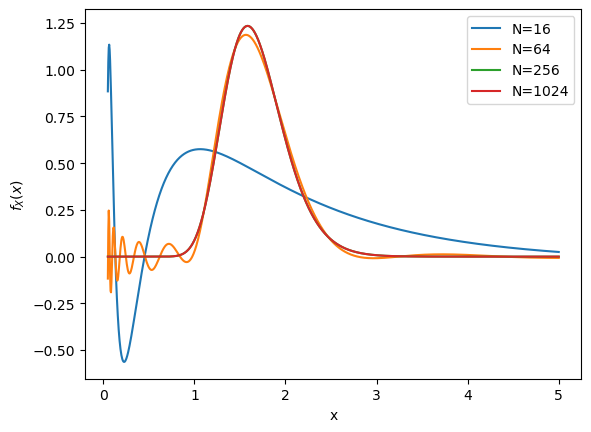

In [130]:
def COSDensity(cf,x,N,a,b):
    i = complex(0.0,1.0) #assigning i=sqrt(-1)
    k = np.linspace(0,N-1,N)
    z= np.zeros([1,N])
    z = k * np.pi / (b-a)
        
    #F_k coefficients
    F_k    = 2.0 / (b - a) * np.real(cf(z) * np.exp(-i * z * a));
    F_k[0] = F_k[0] * 0.5; # adjustment for the first term
    
    #Final calculation
    f_X = np.matmul(F_k , np.cos(np.outer(z, x - a )))
        
    # we output only the first row
    return f_X
def mainCalculation():


    i = complex(0.0, 1.0) #assigning i=sqrt(-1)
    
    # setting for the COS method 
    a = -10
    b = 10
    
    #define the range for the expansion points
    N = [4**x for x in range(2,6,1)]
    
    # setting for normal distribution
    mu = 0.5
    sigma = 0.2 
        
    # Define characteristic function for the normal distribution
    cF = lambda z : np.exp(i * mu * z - 0.5 *sigma**2 * z**2);
    # define domain for density
    y = np.linspace(0.05,5,1000)
    f_YExact = st.lognorm.pdf(y,mu,sigma)   
    plt.figure(1)
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("$f_Y(y)$")
    plt.figure(1)
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("$f_X(x)$")
    for n in N:
        f_Y = 1/y * COSDensity(cF,np.log(y),n,a,b)
        error = np.max(np.abs(f_Y-f_YExact))
        print("For {0} expanansion terms the error is {1}".format(n,error))
        plt.plot(y,f_Y)
    plt.legend(["N=%.0f"%i for i in N])
    
    
mainCalculation()

## Pricing European Options
- Starting from the risk-neutral valuation formula:
$$ V(x,t_0)= e^{-r\Delta t}\mathbb{E}^{\mathbb{Q}} [V(y, T)|x] = e^{-r\Delta t}\int_R V(y,T) f(y|x)dy)$$

Truncating the integration range:
$$ V(x,t_0)= \int_{a}^{b} V(y,T) f(y|x)dy + \epsilon $$

Replace the density by the COS approximation, and interchange summation and integration:
$$\bar{V}(x,t_0)=e^{-r\Delta t}\sum_{n=0}^{'N-1} \mathcal{R} \bigg(\phi\bigg(\frac{n\pi}{b-a};x\bigg)e^{-i\frac{n\pi a}{b-a}}\bigg)H_n$$

where the series coefficients of the payoff are analytic

## Payoff Coefficients
The payoff for European options, in an adjusted log-asset price, i.e
$$y(T) = log\bigg(\frac{S(T)}{K}\bigg)$$
$$ V(T,y) \coloneqq [\bar{a} \cdot K (e^y-1)]^{+}$$
with:
$$\bar{a} = \begin{cases}
1, \text{for a call} \\
-1, \text{for a put} \end{cases} $$

Focusing on a call option, in the case that $a<0<b$ we obtain:
$$ H_n^{call} = \frac{2}{b-a}\int_{0}^{b} K(e^y-1) cos\bigg(n\pi \frac{y-a}{b-a} dy \bigg)$$
$$ H_n^{call} = \frac{2}{b-a} K(\chi_n(0,b) -\psi(0,b))$$

Similarly for a vanilla put we obtain:
$$ H_n^{put} = \frac{2}{b-a} K(-\chi_n(a,0) +\psi(a,0))$$

using these formulas we can get option evaluations for multiple strikes without cos evaluation for each strike

## integrals
The cosine series coefficients, $\chi_n$ of $g(y)=e^y$ on an integration interval $[c,d] \subset [a,b], 
$$\chi_n(c,d) \coloneqq \int_c^d e^y cos\bigg(k\pi \frac{y-a}{b-a}\bigg)dy,$$
and the cosine  series coefficients, $\psi_n$ of $g(y)=1$ on an integration interval $[c,d] \subset [a,b],$
$$ \psi_n(c,d) \coloneqq \int_c^d 1 \cdot cos\bigg(k\pi \frac{y-a}{b-a}\bigg)dy,$$
are known analitically, and since we are dealing with many expansion terms is an advantage to do not compute them numerically

Basic calculus shows:
$$ \chi_n(c,d) \coloneqq \frac{1}{1+ \bigg(\frac{n\pi}{b-a}\bigg)^2} \bigg[cos\bigg(n\pi \frac{d-a}{b-a}\bigg)e^d - cos\bigg(n\pi\frac{d-a}{b-a}\bigg)e^c + \frac{n\pi}{b-a} sin \bigg(n\pi \frac{d-a}{b-a}\bigg)e^d - \frac{n\pi}{b-a} sin \bigg(n\pi \frac{c-a}{b-a}\bigg)e^c\bigg]$$

and
$$ \psi_n(c,d) \coloneqq = \begin{cases} \bigg[ sin \bigg(n\pi \frac{d-a}{b-a}\bigg) - sin \bigg(n\pi \frac{c-a}{b-a}\bigg)\bigg] \frac{b-a}{n\pi}, k>0, \\
(d-c), k<0 \end{cases}$$

## Multiple strikes
$$ U_n = \begin{cases}
 \frac{2}{b-a} K(\chi_n(0,b) -\psi(0,b)), \text{for a call} \\
\frac{2}{b-a} K(- \chi_n(a,0) -\psi(a,0)), \text{for a put} \end{cases}

The pricing formula simplifies for Heston and Lèvy processes:
$$ V(x,t_0) \approx Ke^{-r\Delta t} \mathcal{R}\bigg( \sum_{n=0}^{'N-1} \zeta\bigg(\frac{n\pi}{b-a}\bigg)U_n \cdot e^{in\pi\frac{x-a}{b-a}}\bigg) $$
where $ \zeta(z) \coloneqq \phi(z)$

It took 0.00020657062530517577 seconds to price.
Abs error for strike 80.0 is equal to 1.31E-07
Abs error for strike 90.0 is equal to 3.93E-07
Abs error for strike 100.0 is equal to 3.87E-07
Abs error for strike 110 is equal to 4.32E-07
Abs error for strike 120.0 is equal to 3.50E-07


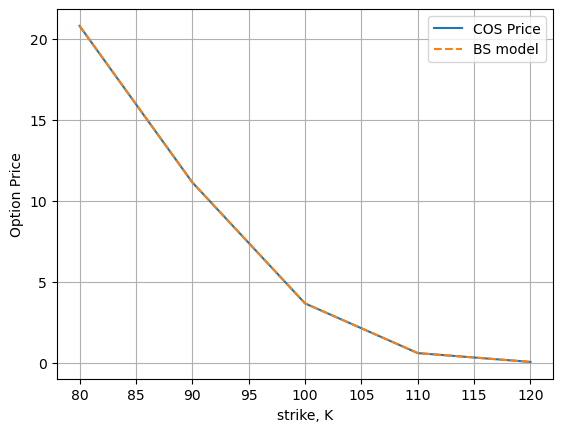

In [131]:
#%%
"""
Created on Thu Nov 27 2018
Pricing of European Call and Put options wit the COS method
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = complex(0.0,1.0) 
    
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a)  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)
       
    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
         
    return value

""" 
Determine coefficients for Put Prices 
"""
def CallPutCoefficients(CP,a,b,k):
    if str(CP).lower()=="c" or str(CP).lower()=="1":            
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
        
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    #Black-Scholes Call option price
    cp = str(CP).lower()
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if cp == "c" or cp == "1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif cp == "p" or cp =="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

def mainCalculation():
    i = complex(0.0,1.0)
    
    CP = "c"
    S0 = 100.0
    r = 0.1
    tau = 0.1
    sigma = 0.25
    K = [80.0, 90.0, 100.0, 110, 120.0]
    N = 4*32
    L = 10
    
    # Definition of the characteristic function for the GBM, this is an input
    # for the COS method
    # Note that Chf does not include coefficient "+iuX(t_0)" this coefficient
    # is included internally in the evaluation
    # In the book we denote this function as \varphi(u)

    cf = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * tau - 0.5 
                          * np.power(sigma, 2.0) * np.power(u, 2.0) * tau)
    
    # Timing results 
    NoOfIterations = 100
    time_start = time.time() 
    for k in range(0,NoOfIterations,1):
        val_COS = CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L)
    time_stop = time.time()
    print("It took {0} seconds to price.".format((time_stop-time_start)/float(NoOfIterations)))
    
    # evaluate analytical Black Scholes equation
    val_Exact = BS_Call_Option_Price(CP,S0,K,sigma,tau,r)
    plt.plot(K,val_COS)
    plt.plot(K,val_Exact,'--')
    plt.xlabel("strike, K")
    plt.ylabel("Option Price")
    plt.legend(["COS Price","BS model"])
    plt.grid()    
    
    #Error comuputation
    error = []
    for i in range(0,len(K)):
        error.append(np.abs(val_COS[i]-val_Exact[i])[0])
        print("Abs error for strike {0} is equal to {1:.2E}".format(K[i],error[i]))
        
mainCalculation()

## Heston model Calibration
During the calibration procedure of the Heston model we search for the model parameters such that the difference between market plain vanilla option prices,
the parameters whose values we search for in this case are $\Omega = {\rho_{S,v},v_0,\bar{v},\kappa,\gamma}$. In order to determine these “optimal” parameters a target function is defined:
$$ L = \sum_i  \sum_j w_{i,j} \bigg( V_c^{mkt}(t_0,S_0,K_i,T_j) - V_c^{hes}(t_0,S_0,K_i,T_j, \Omega)^2\bigg)$$

Often, $w_{i,j} = 1$, however, the target function is often based only on the OTM call and put option prices, which implies a “natural” weighting.
The main difficulty when calibrating the Heston model is that the set Ω includes five parameters that need to be determined, and that the model parameters are not completely “independent”.
The optimization can be accelerated by a reduction of the set of parameters to be optimized.
It is therefore common practice to prescribe (or fix) one of them. Practitioners often fix $\kappa = 0.5$ and optimize parameter $\gamma$. By this, the optimization reduces to four parameters.


Another parameter that may be determined in advance by using heuristics is the initial value of the variance process $v_0$. For maturity time $T$ “close to today” (i.e. $T \rightarrow 0$), one would expect the stock price to behave very much like in the Black-Scholes case. The impact of a stochastic variance process should reduce to zero, in the limit $T \rightarrow 0$. For options with short maturities, the process may therefore be approximated by a process of the following form:
$$ dS(t)= rS(t)dt + \sqrt{v_0}S(t)dW(t)$$
This suggests that for initial variance v0 one may use the square of the ATM implied volatility of an option with the shortest maturity, $v_0 ≈ \sigma^2_{imp}$, for $T \rightarrow 0, as an accurate approximation.



## Heston Characteristic function

$$\phi_{\text{hes}}(z,v_0) = exp\bigg(izr\tau + \frac{v_0}{\gamma^2} \bigg( \frac{1- e^{-D\tau}}{1-Ge^{-D\tau}}\bigg) ( \kappa - i\rho\gamma z -D) \times
exp \bigg( \frac{\kappa v}{\gamma^2} \bigg( \tau(\kappa - i\rho \gamma z - D) - 2 log\bigg( \frac{1-Ge^{-D\tau}}{1-G}\bigg)\bigg)$$
with:
- $D = \sqrt{(\kappa - iz\rho \gamma)^2 + (z^2+iz) \gamma^2}$
- $\tau = T - t_0$
- $G = \frac{\kappa - iz\rho \gamma - D}{\kappa - iz\rho \gamma + D}$

## Loading data


gamma = 3.189418820918259, Kappa= 25.40598103787321,  V_bar= 0.2 
 the value of the loss function is 2.3404112817161847e-05
-0.01000000007833357


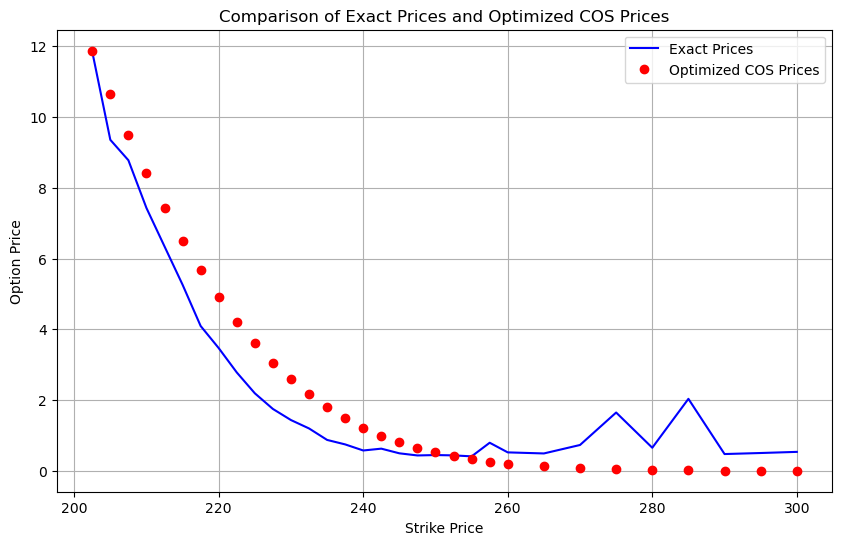

In [166]:
S_0=200
data=pd.read_excel("Apple_call_data.xlsx")

# calibrating the model on OTM call options
data_adjusted=data[data["Strike"]>S_0]

def BS_Call_Put_Option_Price(CP, S_0, K, sigma, ttm, r):
    # Ensure K and other inputs are numpy arrays for element-wise operations
    K = np.array(K)
    sigma = np.array(sigma)
    ttm = np.array(ttm)
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    
    if CP == "c":
        option_price = S_0 * st.norm.cdf(d1) - K * np.exp(-r * ttm) * st.norm.cdf(d2)
    elif CP == "p":
        option_price = K * np.exp(-r * ttm) * st.norm.cdf(-d2) - S_0 * st.norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'c' for call or 'p' for put.")
    return option_price
def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = complex(0.0,1.0)
    D1 = lambda z: np.sqrt(np.power(kappa-gamma*rho*i*z,2)+(z**2+i*z)*gamma**2)
    g  = lambda z: (kappa-gamma*rho*i*z-D1(z))/(kappa-gamma*rho*i*z+D1(z))
    C  = lambda z: (1.0-np.exp(-D1(z)*tau))/(gamma*gamma*(1.0-g(z)*np.exp(-D1(z)*tau)))\
        *(kappa-gamma*rho*i*z-D1(z))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda z: r * i*z *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*z-D1(z))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(z)*np.exp(-D1(z)*tau))/(1.0-g(z)))
    # Characteristic function for the Heston's model    
    cf = lambda z: np.exp(A(z) + C(z)*v0)
    return cf


def main():
    Maturity=datetime.strptime("2024-08-02", "%Y-%m-%d")
    Start_date=datetime.strptime("2024-07-02", "%Y-%m-%d")
    data_adjusted["Last Trade Date (EDT)"] 
    Ttm=(Maturity - Start_date).days/365
    sigma_vec=data_adjusted["Implied Volatility"]
    strike_vec= data_adjusted["Strike"]
    r=0.04
    ### extracting the implied volatility for the strike closer to S_0
    closest_strike_row = data.iloc[(data['Strike'] - 201).abs().argmin()]
    # Extract the implied volatility for that strike
    v_0 = closest_strike_row['Implied Volatility']
    prices_exact= BS_Call_Put_Option_Price("c",S_0,strike_vec,sigma_vec,Ttm,r)
    gamma = 1.0
    kappa = 0.5
    vbar  = 0.2
    rho   = -0.9
    #K = np.linspace(80,S_0*1.5,30)
    cf = ChFHestonModel(r,Ttm,kappa,gamma,vbar,v_0,rho)
    prices_COS_method= CallPutOptionPriceCOSMthd(cf,"c",S_0,r,Ttm,strike_vec,1000,8)
    def LossFunction(params):
        Gamma, Kappa, Vbar = params
        CF = ChFHestonModel(r, Ttm, Kappa, Gamma, Vbar, v_0, rho)
        prices_COS_method = CallPutOptionPriceCOSMthd(CF, "c", S_0, r, Ttm, strike_vec, 1000, 8)
        loss = np.sum(prices_exact - prices_COS_method) ** 2
        return loss
    def FellerConstraint(params):
        Gamma, Kappa, Vbar = params
        return 2 * Kappa * Vbar - Gamma ** 2 + 0.01
    
    initial_params = [1.0, 0.5, 0.2]  # Initial guess for gamma, kappa, vbar
    bounds = [(None,None), (None, None), (0.2, None)]  # Bounds for the parameters
    constraints = {'type': 'ineq', 'fun': FellerConstraint}
    result = minimize(LossFunction, initial_params,bounds=bounds, constraints=constraints, method='COBYLA')
    optimized_params = result.x
    print(f"gamma = {optimized_params[0]}, Kappa= {optimized_params[1]},  V_bar= {optimized_params[2]} ")
    print(f" the value of the loss function is {result.fun}")
    print( 2 * optimized_params[1] * optimized_params[2] - optimized_params[0] ** 2)
    gamma_opt, kappa_opt, vbar_opt = optimized_params
    
    cf_opt = ChFHestonModel(r, Ttm, kappa_opt, gamma_opt, vbar_opt, v_0, -0.7)
    prices_COS_optimized = CallPutOptionPriceCOSMthd(cf_opt, "c", S_0, r, Ttm, strike_vec, 1000, 8) 
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strike_vec, prices_exact, 'b-', label='Exact Prices')
    plt.plot(strike_vec, prices_COS_optimized, 'ro', label='Optimized COS Prices')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Comparison of Exact Prices and Optimized COS Prices')
    plt.legend()
    plt.grid(True)
    plt.show()
main() 